# Object Detection 

## Introduction 

Object detection is one of the many computer vision tasks. It is a combination of object classification and object localization, where the former tries to classify the object given in the image while the latter gives a bounding box around the object in the image. So, object detection aims to classify and locate an object within the image or video. It gives the class of the object and bounding box around the object within the image. 

![alt text](image.png)

## Objectives 

- Downloaded the dataset from [here](https://drive.google.com/file/d/1RVoLlMGx_qqxclsnUgWSoYn8t2McaFJK/view?usp=sharing). Containing annotation files in XML format which contain the image file name, the size, the bounding box, etc. The dataset also contains the image folder which contains all the images. 
- Parse the XML files to get relevant information and transfer them into a dataframe. 
- Load and preprocess the images. Split into train and validation set. 
- Build CNN model for object detection. 

## Importing Modules and Dataset 


In [1]:
# !unzip localization_dataset.zip 

In [2]:
import os 
import cv2 
import csv 
from xml.dom import minidom 
from collections import Counter 

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split 

import tensorflow as tf 
# import tensorflow_addons as tfa 
from tensorflow.keras.models import Model 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, GlobalAveragePooling2D, Dropout, Flatten, Dense 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.metrics import IoU 
# from tfa.losses import GIoULoss 
from tensorflow.keras.utils import plot_model 

import math 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

Structure of the XML files are as below. 

```
<annotation verified="yes">
    <folder>Annotation</folder>
    <filename>cat.0.jpg</filename>
    <path>Cat-PascalVOC-export/Annotations/cat.0.jpg</path>
    <source>
        <database>Unknown</database>
    </source>
    <size>
        <width>256</width>
        <height>256</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
    <name>cat</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
        <xmin>55.35820533192091</xmin>
        <ymin>10.992090947210452</ymin>
        <xmax>197.38757944915255</xmax>
        <ymax>171.24521098163842</ymax>
    </bndbox>
</object>
</annotation>

```

The only information that we need are: 
- filename: the image file name. 
- size: the shape of the image. 
- name: label (class) name of the image. 
- bndbox: the bounding box for object localization. 

In [3]:
# Defining path to annotatino files and image files 
data_path = './dataset/' 
annot_dir = os.path.join(data_path, 'annot/') 
images_dir = os.path.join(data_path, 'images/') 

In [4]:
# Defining function to extract necessary information from xml files 
def extract_xml(annot_file, image_dir): 
    # Parsing the xml file 
    root = minidom.parse(annot_file) 

    # Get the file name of the image 
    files = root.getElementsByTagName('filename') 
    filename = files[0].firstChild.data 

    # Get the shape of the image 
    image_file = os.path.join(image_dir, filename) 
    height, width = cv2.imread(image_file).shape[:2] 

    # Get the label of the image 
    class_name = root.getElementsByTagName('name') 
    label_name = class_name[0].firstChild.data 

    # Get the bounding box of the object in the image 
    xmin = root.getElementsByTagName('xmin') 
    x1 = xmin[0].firstChild.data 

    ymin = root.getElementsByTagName('ymin') 
    y1 = ymin[0].firstChild.data 

    xmax = root.getElementsByTagName('xmax') 
    x2 = xmax[0].firstChild.data 

    ymax = root.getElementsByTagName('ymax') 
    y2 = ymax[0].firstChild.data 

    file_path = image_file 

    if label_name == 'cat': 
        label_name = 0 
    else: 
        label_name = 1 
    
    return filename, width, height, x1, y1, x2, y2, file_path, label_name 


In [5]:
# Get the list of all annot files 
annot_files = os.listdir(annot_dir) 

# Get the relative path of annot files 
for i in range(len(annot_files)): 
    annot_files[i] = os.path.join(annot_dir, annot_files[i]) 

# Extracting information from annot files 
rows = []
for file in annot_files: 
    row = extract_xml(file, images_dir) 
    rows.append(row) 

# Creating dataframe to store all annot files info 
columns = ['filename', 'width', 'height', 'x1', 'y1', 'x2', 'y2', 'file_path', 'label_name'] 

df = pd.DataFrame(rows, columns=columns) 
print('Total images: ', df.shape[0])
df.head(5) 

Total images:  1200


filename  width  height                  x1                  y1  \
0   cat.658.jpg    256     256  5.0259864936440675  1.1570638020833333   
1  dog.8908.jpg    256     256    69.5321989759887  41.075708421610166   
2   cat.651.jpg    256     256  0.1084811970338983   9.256496623411017   
3  dog.9052.jpg    256     256  57.093794138418076    20.8271208509887   
4   cat.230.jpg    256     256   56.80453301553672   94.58983271539547   

                   x2                  y2                      file_path  \
0                 256  247.61129502118644   ./dataset/images/cat.658.jpg   
1  206.06554555084747  253.97515007062145  ./dataset/images/dog.8908.jpg   
2  242.98305084745763  247.61129502118644   ./dataset/images/cat.651.jpg   
3   223.4214777542373  247.03277277542372  ./dataset/images/dog.9052.jpg   
4  245.40567620056495                 256   ./dataset/images/cat.230.jpg   

   label_name  
0           0  
1           1  
2           0  
3           1  
4           0

In [6]:
df.to_csv('dataset.csv', index=None) 

## Preprocess 

- Dividing the bounding boxes coordinates to [0,1] range, so we can scale the box to any image later. 
- Loading all the image files. 

In [7]:
def preprocess(dataset_file): 
    labels = []
    images = [] 
    boxes = [] 

    with open(dataset_file) as file: 
        rows = csv.reader(file) 
        columns = next(iter(rows)) 
        for row in rows: 
            labels.append(int(row[-1]))

            x1 = int(float(row[3]))
            y1 = int(float(row[4]))
            x2 = int(float(row[5]))
            y2 = int(float(row[6]))
            boxes.append([x1, y1, x2, y2])
            
            image = cv2.imread(row[7]) 
            image = cv2.resize(image, (256, 256))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            image = image / 255.0 
            images.append(image) 

    return labels, images, boxes 

In [8]:
dataset_file = 'dataset.csv' 
labels, images, boxes = preprocess(dataset_file) 

Let's take a look at a few of the images and the bounding boxes. 

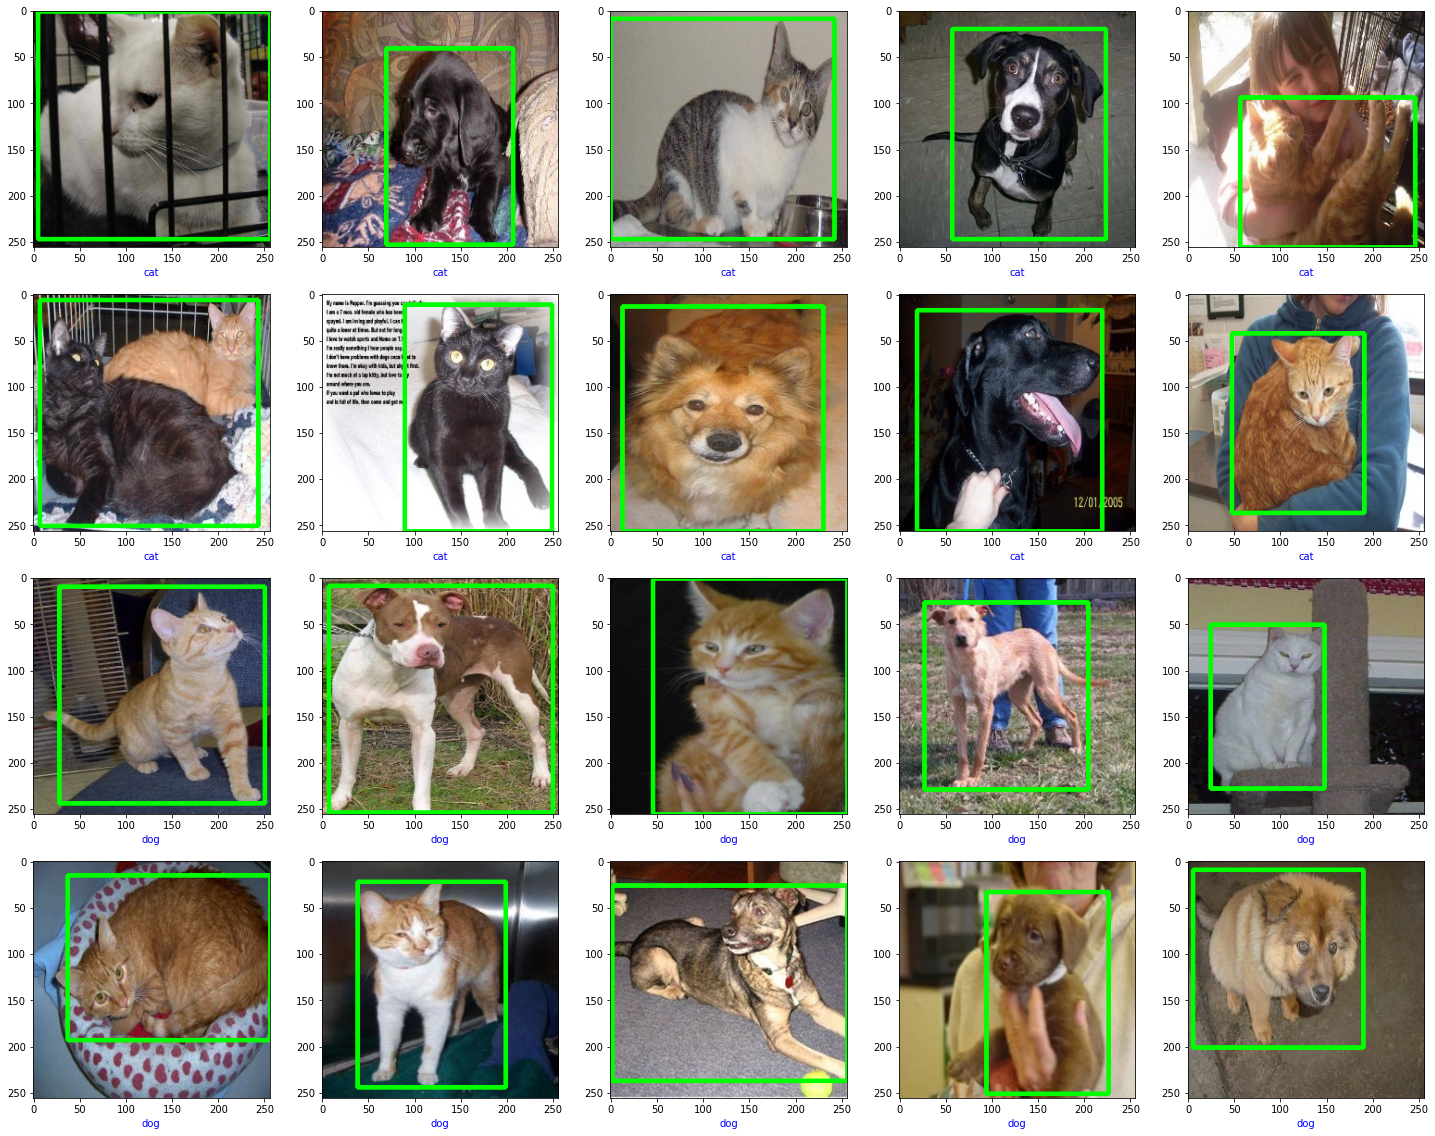

In [9]:
# Showing images 
nrow = 4 
ncol = 5 
thickness = 3 
color = (0, 255.0 / 255.0, 0) # green 

fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*5, nrow*5)) 
count = 0 
for i in range(nrow): 
    for j in range(ncol): 
        cur_ax = ax[i, j] 
        # cur_ax.grid(False) 
        # cur_ax.set_xticks([]) 
        # cur_ax.set_yticks([])

        if count < 10: 
            x1 = boxes[count][0] 
            y1 = boxes[count][1] 
            start_point = (x1, y1) 

            x2 = boxes[count][2] 
            y2 = boxes[count][3] 
            end_point = (x2, y2) 

            label = 'cat' 

            img = images[count]
        else: 
            x1 = boxes[-count][0] 
            y1 = boxes[-count][1] 
            start_point = (x1, y1) 

            x2 = boxes[-count][2] 
            y2 = boxes[-count][3] 
            end_point = (x2, y2) 

            label = 'dog' 

            img = images[-count]
        
        img = cv2.rectangle(img, start_point, end_point, color, thickness)
        cur_ax.imshow(img) 
        cur_ax.set_xlabel(label, color='blue') 
        # fig.set_facecolor('white') 
        count += 1


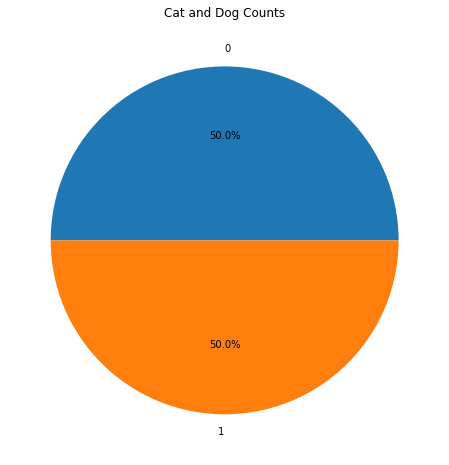

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)) 
ax.pie(x=list(Counter(labels).values()), labels=list(Counter(labels).keys()), autopct='%.1f%%') 
ax.set_title('Cat and Dog Counts') 
fig.set_facecolor('white')

The classes counts are even. 

## Splitting Dataset 

Split 200 images for testing and 1000 for training and validation. Further split the 1000 images to 800 training and 200 validation images. 

In [11]:
train_val_image, test_image, \
    train_val_box, test_box, \
        train_val_class, test_class = train_test_split(images, boxes, labels, 
                                                        test_size=1/6, 
                                                        random_state=17, 
                                                        shuffle=True,
                                                        stratify=labels) 

train_image, val_image, \
    train_box, val_box, \
    train_class, val_class = train_test_split(train_val_image, train_val_box, train_val_class, 
                                                    test_size=0.2, 
                                                    random_state=17, 
                                                    shuffle=True, 
                                                    stratify=train_val_class) 
# train_image, val_image, \
#     train_box, val_box, \
#         train_class, val_class = train_test_split(images, boxes, labels, 
#                                                         test_size=1/6, 
#                                                         random_state=17, 
#                                                         shuffle=True,
#                                                         stratify=labels) 

## Building Model 

We can build the model from scratch of import pre-trained models like ObjectDetection, YOLO, etc. Here I want to use MobilenetV2 for fine-tuning. By dropping the top layers (fully connected layers) that give the final probabilities for each label and adding two fully connected layers: one for classification (cat or dog) and the other for bounding box regression (gives the top left corner and bottom right corner of the bounding box). 

In [12]:
def create_model(): 
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    # base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 
    removed_top = Model(inputs=[base_model.input], outputs=[base_model.layers[90].output]) 
    # removed_top = Model(inputs=[base_model.input], outputs=[base_model.layers[-1].output]) 

    # for layer in removed_top.layers: 
    #     layer.trainable = False

    clf = GlobalAveragePooling2D()(removed_top.output) 
    # clf = Dense(128, activation='relu')(clf) 
    # clf = Dense(64, activation='relu')(clf) 
    # clf = Dense(32, activation='relu')(clf) 
    clf = Dense(1, activation='sigmoid', name='class_out')(clf) 

    loc = Flatten()(removed_top.output) 
    # loc = Dense(128, activation='relu')(loc) 
    # loc = Dropout(0.5)(loc) 
    # loc = Dense(64, activation='relu')(loc) 
    # loc = Dropout(0.5)(loc) 
    # loc = Dense(32, activation='relu')(loc) 
    # loc = Dropout(0.5)(loc) 
    loc = Dense(4, activation='relu', name='box_out')(loc) 

    model = Model(inputs=[removed_top.input], outputs=[clf, loc]) 
    return model 

In [13]:
model = create_model() 

In [14]:
model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

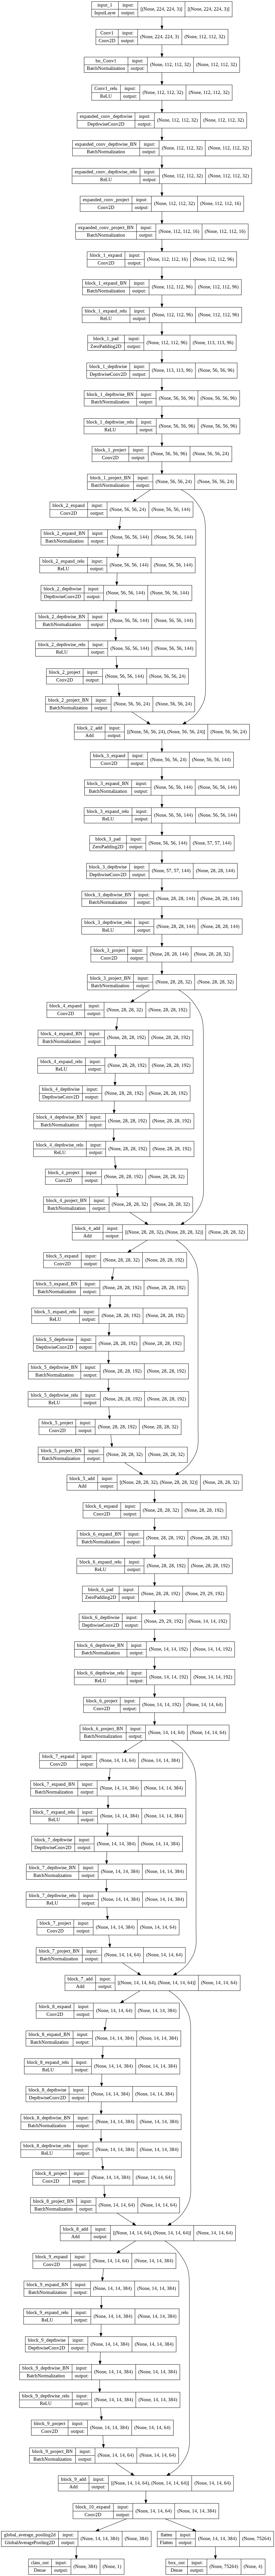

In [15]:
plot_model(model, 'model.png', show_shapes=True) 

In [16]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss={'class_out': 'binary_crossentropy', 
                    'box_out': 'mse'}, 
              optimizer=optimizer, 
              metrics=['accuracy']) 

# optimizer = Adam(learning_rate=0.001)
# model.compile(loss='binary_crossentropy', 
#               optimizer=optimizer, 
#               metrics=['accuracy'])

Since MobileNetV2 takes 224 x 224 pixels images, we need to resize the images from 256 x 256 to 224 x 244. 

In [17]:
def resize_image(image_list): 
    for i in range(len(image_list)): 
        image_list[i] = cv2.resize(image_list[i], (224, 224)) 
    return image_list 

In [23]:
train_image = resize_image(train_image) 
val_image = resize_image(val_image) 
test_image = resize_image(test_image) 

In [19]:
history = model.fit(np.array(train_image), y=[np.array(train_class), np.array(train_box)], 
                    epochs=40, 
                    batch_size=32, 
                    validation_data=(np.array(val_image), [np.array(val_class), np.array(val_box)])
                    )

# history = model.fit(np.array(train_image), y=np.array(train_class), 
#                     epochs=40, 
#                     batch_size=32, 
#                     validation_data=(np.array(val_image), np.array(val_class))
#                     )

Epoch 1/40
25/25 [==============================] - 19s 225ms/step - loss: 4239.3052 - class_out_loss: 0.6479 - box_out_loss: 4238.6577 - class_out_accuracy: 0.6237 - box_out_accuracy: 0.6300 - val_loss: 1908.7142 - val_class_out_loss: 0.7306 - val_box_out_loss: 1907.9834 - val_class_out_accuracy: 0.5350 - val_box_out_accuracy: 0.5650
Epoch 2/40
25/25 [==============================] - 5s 188ms/step - loss: 685.0009 - class_out_loss: 0.5554 - box_out_loss: 684.4455 - class_out_accuracy: 0.7475 - box_out_accuracy: 0.7613 - val_loss: 1094.8130 - val_class_out_loss: 0.7993 - val_box_out_loss: 1094.0138 - val_class_out_accuracy: 0.5100 - val_box_out_accuracy: 0.7200
Epoch 3/40
25/25 [==============================] - 5s 190ms/step - loss: 319.3558 - class_out_loss: 0.5200 - box_out_loss: 318.8358 - class_out_accuracy: 0.7688 - box_out_accuracy: 0.8012 - val_loss: 681.5603 - val_class_out_loss: 0.7072 - val_box_out_loss: 680.8530 - val_class_out_accuracy: 0.5900 - val_box_out_accuracy: 0.71

<Figure size 432x288 with 0 Axes>

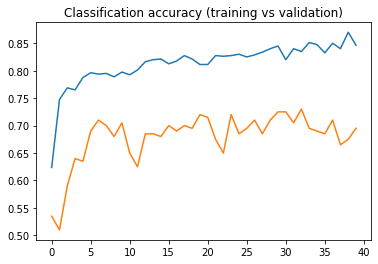

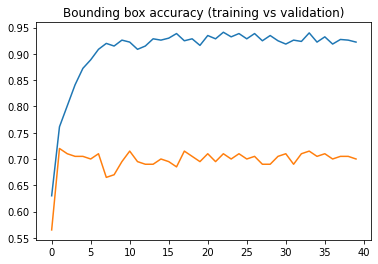

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(history.history['class_out_accuracy']) 
plt.plot(history.history['val_class_out_accuracy']) 
plt.title('Classification accuracy (training vs validation)')
plt.figure() 

plt.plot(history.history['box_out_accuracy']) 
plt.plot(history.history['val_box_out_accuracy']) 
plt.title('Bounding box accuracy (training vs validation)')
plt.figure() 

# plt.plot(history.history['accuracy']) 
# plt.plot(history.history['val_accuracy']) 
# plt.title('Classification accuracy (training vs validation)')
# plt.figure() 

In [27]:
evaluation = model.evaluate(np.array(test_image), [np.array(test_class), np.array(test_box)])
print('Test Classification Accuracy: {}'.format(evaluation[3])) 
print('Test Bounding Box Accuracy: {}'.format(evaluation[4])) 

7/7 [==============================] - 0s 38ms/step - loss: 590.4350 - class_out_loss: 0.5688 - box_out_loss: 589.8661 - class_out_accuracy: 0.7350 - box_out_accuracy: 0.7300
Test Classification Accuracy: 0.7350000143051147
Test Bounding Box Accuracy: 0.7300000190734863


In [24]:
predictions = model.predict(np.array(test_image))

cat 0
[ 24.808674  28.43842  245.47733  255.84407 ] [57, 30, 197, 256]


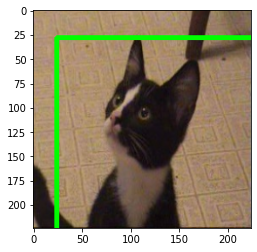

In [28]:
pred1 = 'cat' if predictions[0][0] < 0.5 else 'dog' 
real_class = val_class[0] 
print(pred1, real_class) 

box1 = predictions[1][0] 
real_box = val_box[0] 
print(box1, real_box) 

img = val_image[0] 
img = cv2.rectangle(img, (int(box1[0]), int(box1[1])), (int(box1[2]), int(box1[3])), color=color, thickness=3)
plt.imshow(img)

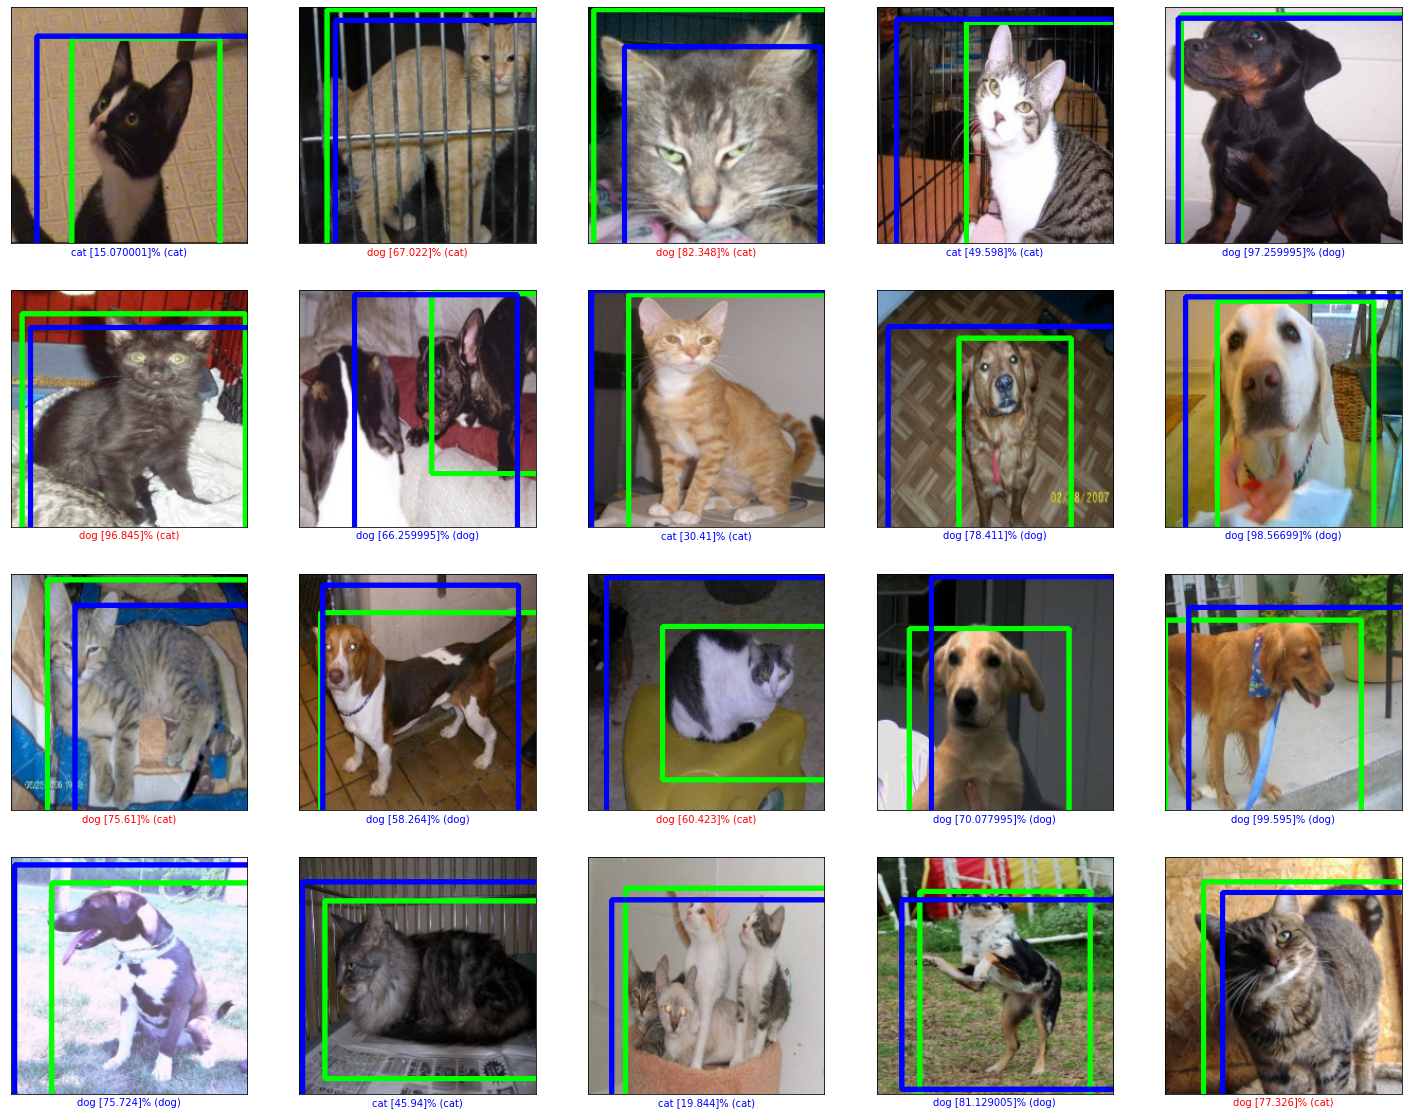

In [29]:
nrow = 4 
ncol = 5 
thickness = 3 
true_color = (0, 255.0 / 255.0, 0) # green 
pred_color = (0, 0, 255.0 / 255.0) # blue

fig, ax = plt.subplots(nrow, ncol, figsize=(ncol*5, nrow*5)) 
count = 0 
for i in range(nrow): 
    for j in range(ncol): 
        cur_ax = ax[i, j] 
        cur_ax.grid(False) 
        cur_ax.set_xticks([]) 
        cur_ax.set_yticks([])

        pred_label = 'cat' if predictions[0][count] < 0.5 else 'dog' 
        true_label = 'cat' if val_class[count] < 0.5 else 'dog' 

        pred_box = predictions[1][count] 
        true_box = val_box[count] 

        img = val_image[count]
        img = cv2.rectangle(img, (true_box[0], true_box[1]), (true_box[2], true_box[3]), true_color, thickness)
        img = cv2.rectangle(img, (int(pred_box[0]), int(pred_box[1])), (int(pred_box[2]), int(pred_box[3])), pred_color, thickness)
        cur_ax.imshow(img) 

        if pred_label == true_label: 
            text_color = 'blue' 
        else: 
            text_color = 'red' 

        cur_ax.set_xlabel(f'{pred_label} {100*predictions[0][count].round(5)}% ({true_label})', color = text_color)
        count += 1
        count += 1